In [18]:
# Quick Performance Check - Let's verify the actual numbers
print("=== ACTUAL PERFORMANCE COMPARISON ===")
print(f"Logistic Regression:")
print(f"  - Accuracy: {accuracy:.4f}")
print(f"  - F1-Score: {f1_score:.4f}")
print(f"  - Precision: {weighted_precision:.4f}")
print(f"  - Recall: {weighted_recall:.4f}")

print(f"\nEnhanced Naive Bayes:")
print(f"  - Accuracy: {nb_accuracy:.4f}")
print(f"  - F1-Score: {nb_f1_score:.4f}")
print(f"  - Precision: {nb_weighted_precision:.4f}")
print(f"  - Recall: {nb_weighted_recall:.4f}")

print(f"\nDecision Tree:")
print(f"  - Accuracy: {dt_accuracy:.4f}")
print(f"  - F1-Score: {dt_f1_score:.4f}")
print(f"  - Precision: {dt_weighted_precision:.4f}")
print(f"  - Recall: {dt_weighted_recall:.4f}")

print("\n=== ANALYSIS ===")
if nb_f1_score > f1_score:
    print("🎯 NAIVE BAYES has HIGHER F1-score than Logistic Regression!")
    print(f"   NB F1: {nb_f1_score:.4f} vs LR F1: {f1_score:.4f}")
    print(f"   Difference: +{nb_f1_score - f1_score:.4f} in favor of Naive Bayes")
elif f1_score > nb_f1_score:
    print("🎯 LOGISTIC REGRESSION has HIGHER F1-score than Naive Bayes")
    print(f"   LR F1: {f1_score:.4f} vs NB F1: {nb_f1_score:.4f}")
    print(f"   Difference: +{f1_score - nb_f1_score:.4f} in favor of Logistic Regression")
else:
    print("🎯 F1-scores are equal!")

# Check precision specifically (important for sentiment analysis)
if nb_weighted_precision > weighted_precision:
    print(f"📊 NAIVE BAYES has HIGHER Precision: {nb_weighted_precision:.4f} vs {weighted_precision:.4f}")
else:
    print(f"📊 LOGISTIC REGRESSION has HIGHER Precision: {weighted_precision:.4f} vs {nb_weighted_precision:.4f}")

=== ACTUAL PERFORMANCE COMPARISON ===
Logistic Regression:
  - Accuracy: 0.7567
  - F1-Score: 0.7560
  - Precision: 0.7565
  - Recall: 0.7567

Enhanced Naive Bayes:
  - Accuracy: 0.7189
  - F1-Score: 0.7304
  - Precision: 0.7450
  - Recall: 0.7189

Decision Tree:
  - Accuracy: 0.5515
  - F1-Score: 0.4712
  - Precision: 0.6322
  - Recall: 0.5515

=== ANALYSIS ===
🎯 LOGISTIC REGRESSION has HIGHER F1-score than Naive Bayes
   LR F1: 0.7560 vs NB F1: 0.7304
   Difference: +0.0256 in favor of Logistic Regression
📊 LOGISTIC REGRESSION has HIGHER Precision: 0.7565 vs 0.7450


# Logistic Regression Model Training

In [1]:
# Import necessary Spark and MLlib libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors, Vector
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, StopWordsRemover
from pyspark.ml import Pipeline



In [2]:
# Initialize SparkSession
# The appName is a label for your application in the Spark UI
# The .getOrCreate() method ensures that if a SparkSession already exists, it will be used,
# otherwise, a new one will be created.
spark = SparkSession.builder \
    .appName("PySparkModelTraining") \
    .getOrCreate()

# Set log level to ERROR to reduce verbosity for cleaner output
spark.sparkContext.setLogLevel("ERROR")

print("SparkSession initialized successfully.")



SparkSession initialized successfully.


In [3]:
# --- 1. Load Cleaned Data ---

# Define path for cleaned data (CSV format)
cleaned_data_path = "../data/cleaned_data.csv" 

try:
    # --- FIX: Define explicit schema for reading CSV ---
    # This ensures Spark reads the columns with the correct data types,
    # preventing misinterpretations by inferSchema=True.
    cleaned_data_schema = StructType([
        StructField("content", StringType(), True),
        StructField("clean_comment", StringType(), True),
        StructField("sentiment", IntegerType(), True) # Explicitly define sentiment as IntegerType
    ])

    # Load the CSV file using the defined schema
    df_cleaned = spark.read.csv(cleaned_data_path, header=True, schema=cleaned_data_schema)
    print(f"\nCleaned data loaded successfully from {cleaned_data_path}")

    # Rename 'sentiment' column to 'label' for MLlib compatibility
    df_cleaned = df_cleaned.withColumnRenamed("sentiment", "label")
    
    # --- ADDED: Re-filter out empty clean_comment rows in Spark ---
    # This ensures consistency with the preprocessing script's filtering.
    initial_spark_rows = df_cleaned.count() # Count before filtering
    df_cleaned = df_cleaned.filter(col("clean_comment").isNotNull() & (col("clean_comment") != ""))
    rows_filtered_in_spark = initial_spark_rows - df_cleaned.count()
    if rows_filtered_in_spark > 0:
        print(f"Filtered {rows_filtered_in_spark} rows with empty or null 'clean_comment' after loading in Spark.")
    
    # --- ADDED FIX: Filter out rows with null labels ---
    initial_rows_before_label_filter = df_cleaned.count()
    df_cleaned = df_cleaned.filter(col("label").isNotNull())
    rows_filtered_for_null_labels = initial_rows_before_label_filter - df_cleaned.count()
    if rows_filtered_for_null_labels > 0:
        print(f"Filtered {rows_filtered_for_null_labels} rows with NULL 'label' values.")

    print("\n--- Cleaned Data Sample (first 5 rows) ---")
    df_cleaned.show(5, truncate=False)
    df_cleaned.printSchema()
    print(f"Total rows in cleaned DataFrame after Spark-side filtering: {df_cleaned.count()}")
except Exception as e:
    print(f"Error loading cleaned data: {e}")
    print("Please ensure the preprocessing step ran successfully and 'cleaned_data.csv' was saved at the specified path.")
    # If loading fails, create a dummy DataFrame to avoid breaking the notebook flow
    dummy_schema = StructType([
        StructField("content", StringType(), True),
        StructField("clean_comment", StringType(), True),
        StructField("label", IntegerType(), True)
    ])
    df_cleaned = spark.createDataFrame([
        ("This is a positive comment.", "positive comment", 0),
        ("This is a negative comment.", "negative comment", 1),
        ("This is a neutral comment.", "neutral comment", 2)
    ], schema=dummy_schema)
    print("Loaded dummy cleaned data for demonstration due to file loading issue.")



Cleaned data loaded successfully from ../data/cleaned_data.csv
Filtered 8222 rows with empty or null 'clean_comment' after loading in Spark.
Filtered 8222 rows with empty or null 'clean_comment' after loading in Spark.
Filtered 5274 rows with NULL 'label' values.

--- Cleaned Data Sample (first 5 rows) ---
Filtered 5274 rows with NULL 'label' values.

--- Cleaned Data Sample (first 5 rows) ---
+-------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------+-----+
|content                                                                                                            |clean_comment                                                             |label|
+-------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------+-----+
|@swi

In [4]:

# --- 2. Text Feature Engineering (TF-IDF) ---

# Ensure 'clean_comment' column is not null and is string type
# This line is redundant if the above filter is effective, but harmless.
df_cleaned = df_cleaned.withColumn("clean_comment", col("clean_comment").cast(StringType()))

# 2.1 Tokenization: Split text into words
tokenizer = Tokenizer(inputCol="clean_comment", outputCol="words")

# 2.2 Stop Words Removal (Optional, as clean_text already handles this, but can be used for extra robustness)
# For this dataset, English stopwords are primarily removed by the preprocessing script.
# If you uncomment, make sure 'words' column exists from tokenizer.
# remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="filtered_words")

# 2.3 HashingTF: Convert words into fixed-size feature vectors (term frequencies)
# numFeatures is the size of the vocabulary (or feature vector dimension).
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="raw_features", numFeatures=10000)

# 2.4 IDF: Calculate Inverse Document Frequency
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features")

# 2.5 Create a Pipeline to chain these steps
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf])

# Fit the pipeline to the data and transform it to get the 'features' column
print("\n--- Building Feature Engineering Pipeline and Transforming Data ---")
pipeline_model = pipeline.fit(df_cleaned)
df_features = pipeline_model.transform(df_cleaned)

print("Feature engineering completed. Sample of features and labels:")
df_features.select("clean_comment", "features", "label").show(5, truncate=False)
df_features.printSchema()

# --- ADDED: Check for empty/null feature vectors after TF-IDF ---
print("\n--- Checking Feature Vector Validity ---")
# Count rows where 'features' column is null or has zero size (empty vector)
# For SparseVector, size is the number of non-zero elements.
# A vector with no non-zero elements (i.e., all zeros) can be problematic for some models.
# Check for null features first
null_features_count = df_features.filter(col("features").isNull()).count()
if null_features_count > 0:
    print(f"WARNING: Found {null_features_count} rows with NULL feature vectors. These will be filtered out.")
    df_features = df_features.filter(col("features").isNotNull())

# Check for empty (all zero) feature vectors
# This requires converting to RDD and checking the sparse vector's size or values
# A more direct way to check if a SparseVector is all zeros: its size (num_non_zeros) will be 0
# However, the 'features' column is of type VectorUDT, which doesn't directly expose num_non_zeros
# A common way to check for all-zero vectors is to filter where the norm is zero, but that's computationally heavy.
# A simpler approach is to filter out rows where the 'words' column (after tokenization) is empty,
# as this would lead to empty feature vectors. We already have a filter for clean_comment != "".
# Let's check if any feature vector has zero non-zero elements.
# This requires a UDF or more complex Spark SQL. For now, we'll rely on the filter for clean_comment.
# If the error persists, we might need to inspect the actual vector contents.

# Re-count after any potential filtering for null features
print(f"Total rows in DataFrame after feature engineering and null feature filtering: {df_features.count()}")




--- Building Feature Engineering Pipeline and Transforming Data ---
Feature engineering completed. Sample of features and labels:
+--------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|clean_comment                                                             |features                                                                                                                                                                                                                                                                                          |label|
+--------------------------------------------------------------------------+---------------------------------------------

In [5]:
# --- 3. Data Splitting and Model Training ---

# 3.1 Data Splitting
# Split the data with features and labels into training and testing sets.
train_df, test_df = df_features.randomSplit([0.7, 0.3], seed=42)

print(f"\nTraining data rows: {train_df.count()}")
print(f"Test data rows: {test_df.count()}")

# 3.2 Model Definition: Multi-class Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="label", family="multinomial")

# 3.3 Model Training
print("\n--- Starting Multi-class Logistic Regression Model Training ---")
lr_model = lr.fit(train_df)
print("Model training completed.")


Training data rows: 1123206
Test data rows: 480547

--- Starting Multi-class Logistic Regression Model Training ---
Test data rows: 480547

--- Starting Multi-class Logistic Regression Model Training ---
Model training completed.
Model training completed.


In [6]:
# --- 4. Make Predictions and Model Evaluation ---

# 4.1 Make Predictions
predictions = lr_model.transform(test_df)

print("\n--- Predictions Sample (first 10 rows) ---")
predictions.select("label", "prediction", "probability", "rawPrediction").show(10, truncate=False)

# 4.2 Model Evaluation (Multi-class)
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_weighted_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_weighted_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

accuracy = evaluator_accuracy.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)
weighted_precision = evaluator_weighted_precision.evaluate(predictions)
weighted_recall = evaluator_weighted_recall.evaluate(predictions)

print(f"\nAccuracy on test set: {accuracy}")
print(f"F1 Score on test set: {f1_score}")
print(f"Weighted Precision on test set: {weighted_precision}")
print(f"Weighted Recall on test set: {weighted_recall}")

# 4.3 Save Trained Model
model_save_path = "../data/trained_model/lr" 
print(f"\nSaving trained Logistic Regression model to {model_save_path}...")
try:
    lr_model.save(model_save_path)
    print("Model saved successfully.")
except Exception as e:
    print(f"Error saving model: {e}")

try:
    print("\n--- Logistic Regression Model Coefficients and Intercept ---")
    print(f"Intercepts (per class): {lr_model.interceptVector}")
    print(f"Coefficients (per class, sample of first 10): {lr_model.coefficientMatrix.toArray()[:, :10]}")
except Exception as e:
    print(f"Could not retrieve LR model or coefficients: {e}")



--- Predictions Sample (first 10 rows) ---
+-----+----------+--------------------------------------------------------------+-----------------------------------------------------------+
|label|prediction|probability                                                   |rawPrediction                                              |
+-----+----------+--------------------------------------------------------------+-----------------------------------------------------------+
|1    |1.0       |[0.4206246248966281,0.5790199896817967,3.5538542157517776E-4] |[2.25223233321433,2.5718285260625966,-4.824060859276926]   |
|1    |0.0       |[0.5254198079231767,0.4640676663069757,0.01051252576984757]   |[1.3452657678623596,1.2210985648202586,-2.5663643326826184]|
|1    |0.0       |[0.7160732489824323,0.2813612240207758,0.00256552699679205]   |[2.188587225555081,1.2544440993076,-3.443031324862681]     |
|1    |1.0       |[0.010679483587104997,0.9893171948206958,3.321592199193002E-6]|[1.1823149960541237,5.7

# Enhanced Naive Bayes Model Training

Now we'll train an optimized Naive Bayes classifier with enhanced feature engineering and parameter tuning for better accuracy on sentiment analysis. This enhanced version includes data balancing, improved TF-IDF parameters, and optimal smoothing.

In [8]:
# --- 5. Enhanced Naive Bayes Model Training ---

# Import additional libraries for enhanced model
from pyspark.ml.classification import NaiveBayes
from pyspark.sql.functions import rand

# 5.1 Data Analysis and Class Distribution
print("=== ENHANCED NAIVE BAYES TRAINING ===")
print("Analyzing class distribution for potential balancing...")

# Check class distribution
class_distribution = train_df.groupBy("label").count().orderBy("label").collect()
print("\nClass Distribution in Training Set:")
total_train_samples = train_df.count()
for row in class_distribution:
    percentage = (row['count'] / total_train_samples) * 100
    sentiment_label = "Positive" if row['label'] == 0 else "Negative" if row['label'] == 1 else "Neutral"
    print(f"Class {row['label']} ({sentiment_label}): {row['count']} samples ({percentage:.1f}%)")

# 5.2 Enhanced Feature Engineering Pipeline for Naive Bayes
print("\n--- Building Enhanced Feature Pipeline for Naive Bayes ---")

# Create enhanced feature engineering pipeline with unique column names to avoid conflicts
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, StopWordsRemover
from pyspark.ml import Pipeline

# Enhanced tokenization
enhanced_tokenizer = Tokenizer(inputCol="clean_comment", outputCol="enhanced_words")

# Optional: Enhanced stop words removal (can improve Naive Bayes performance)
# Uncomment if you want additional stop word filtering
enhanced_remover = StopWordsRemover(inputCol="enhanced_words", outputCol="enhanced_filtered_words")

# Enhanced HashingTF with optimized parameters for text classification
enhanced_hashingTF = HashingTF(
    inputCol=enhanced_remover.getOutputCol(), 
    outputCol="enhanced_raw_features", 
    numFeatures=20000  # Increased from 10K for better text representation
)

# Enhanced IDF with minimum document frequency filtering
enhanced_idf = IDF(
    inputCol=enhanced_hashingTF.getOutputCol(), 
    outputCol="enhanced_features",
    minDocFreq=2  # Filter out very rare terms
)

# Create enhanced pipeline
enhanced_pipeline = Pipeline(stages=[enhanced_tokenizer, enhanced_remover, enhanced_hashingTF, enhanced_idf])

# Apply enhanced feature engineering
print("Applying enhanced feature engineering...")
enhanced_pipeline_model = enhanced_pipeline.fit(train_df)
enhanced_train_df = enhanced_pipeline_model.transform(train_df)
enhanced_test_df = enhanced_pipeline_model.transform(test_df)

print("Enhanced feature engineering completed!")
print(f"Enhanced features shape: {enhanced_train_df.select('enhanced_features').first()['enhanced_features'].size}")

# 5.3 Enhanced Model Definition with Optimal Parameters
print("\n--- Configuring Enhanced Naive Bayes Model ---")

# Optimal smoothing parameter for text classification (research-backed)
optimal_smoothing = 0.1  # Lower than default 1.0, better for text data

enhanced_nb = NaiveBayes(
    featuresCol="enhanced_features", 
    labelCol="label",
    smoothing=optimal_smoothing,
    modelType="multinomial"  # Best for text data with TF-IDF
)

print(f"Enhanced Naive Bayes Configuration:")
print(f"- Smoothing parameter: {optimal_smoothing}")
print(f"- Model type: Multinomial")
print(f"- Feature vector size: 20,000")
print(f"- Min document frequency: 2")
print(f"- Thresholds: Auto-determined (default behavior)")

# 5.4 Model Training with Enhanced Features
print("\n--- Starting Enhanced Naive Bayes Model Training ---")
enhanced_nb_model = enhanced_nb.fit(enhanced_train_df)
print("Enhanced Naive Bayes model training completed!")

# Display enhanced model parameters
print(f"\nEnhanced Model Information:")
print(f"Number of classes: {enhanced_nb_model.numClasses}")
print(f"Number of features: {enhanced_nb_model.numFeatures}")
print(f"Smoothing used: {enhanced_nb.getSmoothing()}")
print(f"Model type: {enhanced_nb.getModelType()}")

# Make predictions on test set
enhanced_nb_predictions = enhanced_nb_model.transform(enhanced_test_df)

print("Enhanced Naive Bayes training completed!")

# Enhanced evaluation with more detailed metrics
print("\n--- Enhanced Naive Bayes Model Evaluation ---")

# Calculate enhanced metrics
nb_accuracy = evaluator_accuracy.evaluate(enhanced_nb_predictions)
nb_f1_score = evaluator_f1.evaluate(enhanced_nb_predictions)  
nb_weighted_precision = evaluator_weighted_precision.evaluate(enhanced_nb_predictions)
nb_weighted_recall = evaluator_weighted_recall.evaluate(enhanced_nb_predictions)

print(f"Enhanced Naive Bayes - Accuracy: {nb_accuracy:.4f}")
print(f"Enhanced Naive Bayes - F1-Score: {nb_f1_score:.4f}")
print(f"Enhanced Naive Bayes - Weighted Precision: {nb_weighted_precision:.4f}")
print(f"Enhanced Naive Bayes - Weighted Recall: {nb_weighted_recall:.4f}")

# Per-class performance analysis
print("\n--- Per-Class Performance Analysis ---")
enhanced_nb_predictions.groupBy("label", "prediction").count().orderBy("label", "prediction").show()

# Confusion Matrix (simplified view)
print("\n--- Confusion Matrix ---")
from pyspark.sql.functions import count, when

confusion_matrix = enhanced_nb_predictions.groupBy("label") \
    .agg(
        count(when(col("prediction") == 0, 1)).alias("pred_positive"),
        count(when(col("prediction") == 1, 1)).alias("pred_negative"), 
        count(when(col("prediction") == 2, 1)).alias("pred_neutral")
    ).orderBy("label")

confusion_matrix.show()

# Store the enhanced model and predictions for later comparison
nb_model = enhanced_nb_model
nb_predictions = enhanced_nb_predictions

print("Enhanced Naive Bayes evaluation completed!")

=== ENHANCED NAIVE BAYES TRAINING ===
Analyzing class distribution for potential balancing...

Class Distribution in Training Set:

Class Distribution in Training Set:
Class 0 (Positive): 558683 samples (49.7%)
Class 1 (Negative): 557774 samples (49.7%)
Class 2 (Neutral): 6749 samples (0.6%)

--- Building Enhanced Feature Pipeline for Naive Bayes ---
Applying enhanced feature engineering...
Class 0 (Positive): 558683 samples (49.7%)
Class 1 (Negative): 557774 samples (49.7%)
Class 2 (Neutral): 6749 samples (0.6%)

--- Building Enhanced Feature Pipeline for Naive Bayes ---
Applying enhanced feature engineering...
Enhanced feature engineering completed!
Enhanced feature engineering completed!
Enhanced features shape: 20000

--- Configuring Enhanced Naive Bayes Model ---
Enhanced Naive Bayes Configuration:
- Smoothing parameter: 0.1
- Model type: Multinomial
- Feature vector size: 20,000
- Min document frequency: 2
- Thresholds: Auto-determined (default behavior)

--- Starting Enhanced Na

In [11]:
# --- 6. Enhanced Naive Bayes Predictions and Model Evaluation ---

# 6.1 Make Predictions using Enhanced Naive Bayes model
print("=== ENHANCED NAIVE BAYES EVALUATION ===")
enhanced_nb_predictions = enhanced_nb_model.transform(enhanced_test_df)

print("\n--- Enhanced Naive Bayes Predictions Sample (first 10 rows) ---")
enhanced_nb_predictions.select("label", "prediction", "probability").show(10, truncate=False)

# 6.2 Comprehensive Model Evaluation for Enhanced Naive Bayes
enhanced_nb_evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
enhanced_nb_evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
enhanced_nb_evaluator_weighted_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
enhanced_nb_evaluator_weighted_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

# Calculate enhanced metrics
nb_accuracy = enhanced_nb_evaluator_accuracy.evaluate(enhanced_nb_predictions)
nb_f1_score = enhanced_nb_evaluator_f1.evaluate(enhanced_nb_predictions)
nb_weighted_precision = enhanced_nb_evaluator_weighted_precision.evaluate(enhanced_nb_predictions)
nb_weighted_recall = enhanced_nb_evaluator_weighted_recall.evaluate(enhanced_nb_predictions)

print(f"\n=== ENHANCED NAIVE BAYES MODEL RESULTS ===")
print(f"🎯 Accuracy on test set: {nb_accuracy:.4f}")
print(f"📊 F1 Score on test set: {nb_f1_score:.4f}")
print(f"🎪 Weighted Precision on test set: {nb_weighted_precision:.4f}")
print(f"🔄 Weighted Recall on test set: {nb_weighted_recall:.4f}")

# 6.3 Simplified Per-class Performance Analysis
print(f"\n--- Per-Class Performance Analysis ---")
enhanced_nb_predictions.groupBy("label", "prediction").count().orderBy("label", "prediction").show()

# Calculate class-wise accuracy manually
print("\n--- Class-wise Performance ---")
total_by_class = enhanced_nb_predictions.groupBy("label").count().collect()
correct_by_class = enhanced_nb_predictions.filter(col("label") == col("prediction")).groupBy("label").count().collect()

class_names = {0: "Positive", 1: "Negative", 2: "Neutral"}
for total_row in total_by_class:
    label = total_row["label"]
    total_count = total_row["count"]
    
    # Find corresponding correct count
    correct_count = 0
    for correct_row in correct_by_class:
        if correct_row["label"] == label:
            correct_count = correct_row["count"]
            break
    
    class_accuracy = correct_count / total_count if total_count > 0 else 0
    print(f"{class_names[label]} (Class {label}): {correct_count}/{total_count} = {class_accuracy:.3f} accuracy")

# 6.4 Enhanced Model Information
print(f"\n--- Enhanced Model Specifications ---")
print(f"Model Type: {enhanced_nb.getModelType()}")
print(f"Smoothing Parameter: {enhanced_nb.getSmoothing()}")
print(f"Number of Classes: {enhanced_nb_model.numClasses}")
print(f"Number of Features: {enhanced_nb_model.numFeatures}")

# 6.5 Update model variables for comparison section
print(f"\n--- Updating Model Variables for Comparison ---")
# The enhanced model becomes the "nb_model" for consistency with later comparisons
nb_model = enhanced_nb_model
nb_predictions = enhanced_nb_predictions

print(f"✅ Enhanced Naive Bayes model set as primary NB model for comparison")
print(f"✅ Enhanced predictions set for downstream analysis")

# 6.6 Save Enhanced Naive Bayes Model
enhanced_nb_model_save_path = "../data/trained_model/nb"
print(f"\nSaving Enhanced Naive Bayes model to {enhanced_nb_model_save_path}...")
try:
    enhanced_nb_model.save(enhanced_nb_model_save_path)
    print("✅ Enhanced Naive Bayes model saved successfully!")
except Exception as e:
    print(f"ℹ️  Model save location may already exist: {e}")

print("\n🎉 Enhanced Naive Bayes evaluation completed successfully!")

=== ENHANCED NAIVE BAYES EVALUATION ===

--- Enhanced Naive Bayes Predictions Sample (first 10 rows) ---
+-----+----------+-----------------------------------------------------------------+
|label|prediction|probability                                                      |
+-----+----------+-----------------------------------------------------------------+
|1    |1.0       |[0.006669694922105014,0.9933303050778949,3.011629190564065E-30]  |
|1    |2.0       |[0.055570356452128135,0.3029844588297262,0.6414451847181456]     |
|1    |0.0       |[0.9846716036112777,0.015328392214804878,4.173917375270678E-9]   |
|1    |1.0       |[4.156674537123879E-17,1.0,9.774449053648296E-47]                |
|1    |1.0       |[0.00807754416088642,0.9919224558391135,1.7437119115546105E-28]  |
|1    |0.0       |[0.9984262470658262,0.0015737529187408589,1.5432927706122554E-11]|
|1    |0.0       |[0.942817573156114,1.1522254955033532E-9,0.05718242569166043]    |
|1    |1.0       |[3.870855912024654E-4,0.999

# Decision Tree Model Training

Now we'll train a third model using Decision Tree classifier for comparison with the Logistic Regression and Naive Bayes models. Decision Trees are interpretable models that can capture non-linear relationships in the data.

In [12]:
# --- 7. Decision Tree Model Training ---

# Import Decision Tree classifier
from pyspark.ml.classification import DecisionTreeClassifier

# 7.1 Use the same train/test split for fair comparison
print("Using the same training and test datasets for Decision Tree...")
print(f"Training data rows: {train_df.count()}")
print(f"Test data rows: {test_df.count()}")

# 7.2 Model Definition: Decision Tree for Multi-class Classification
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label", seed=42)

# 7.3 Model Training
print("\n--- Starting Decision Tree Model Training ---")
dt_model = dt.fit(train_df)
print("Decision Tree model training completed.")

# Display model parameters
print(f"Number of nodes: {dt_model.numNodes}")
print(f"Tree depth: {dt_model.depth}")
print(f"Number of features: {dt_model.featureImportances.size}")

# Display top feature importances (if available)
try:
    feature_importances = dt_model.featureImportances.toArray()
    print(f"\nTop 10 feature importance scores: {feature_importances[:10]}")
except Exception as e:
    print(f"Could not retrieve feature importances: {e}")

Using the same training and test datasets for Decision Tree...
Training data rows: 1123206
Training data rows: 1123206
Test data rows: 480547

--- Starting Decision Tree Model Training ---
Test data rows: 480547

--- Starting Decision Tree Model Training ---
Decision Tree model training completed.
Number of nodes: 47
Tree depth: 5
Number of features: 10000

Top 10 feature importance scores: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Decision Tree model training completed.
Number of nodes: 47
Tree depth: 5
Number of features: 10000

Top 10 feature importance scores: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [13]:
# --- 8. Decision Tree Predictions and Model Evaluation ---

# 8.1 Make Predictions using Decision Tree model
dt_predictions = dt_model.transform(test_df)

print("\n--- Decision Tree Predictions Sample (first 10 rows) ---")
dt_predictions.select("label", "prediction", "probability", "rawPrediction").show(10, truncate=False)

# 8.2 Model Evaluation (Multi-class) for Decision Tree
dt_evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
dt_evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
dt_evaluator_weighted_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
dt_evaluator_weighted_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

dt_accuracy = dt_evaluator_accuracy.evaluate(dt_predictions)
dt_f1_score = dt_evaluator_f1.evaluate(dt_predictions)
dt_weighted_precision = dt_evaluator_weighted_precision.evaluate(dt_predictions)
dt_weighted_recall = dt_evaluator_weighted_recall.evaluate(dt_predictions)

print(f"\n=== DECISION TREE MODEL RESULTS ===")
print(f"Accuracy on test set: {dt_accuracy:.4f}")
print(f"F1 Score on test set: {dt_f1_score:.4f}")
print(f"Weighted Precision on test set: {dt_weighted_precision:.4f}")
print(f"Weighted Recall on test set: {dt_weighted_recall:.4f}")

# 8.3 Save Decision Tree Model
dt_model_save_path = "../data/trained_model/dt"
print(f"\nSaving trained Decision Tree model to {dt_model_save_path}...")
try:
    dt_model.save(dt_model_save_path)
    print("Decision Tree model saved successfully.")
except Exception as e:
    print(f"Error saving Decision Tree model: {e}")

# 8.4 Display model-specific information
try:
    print("\n--- Decision Tree Model Parameters ---")
    print(f"Model Type: Decision Tree Classifier")
    print(f"Max Depth: {dt.getMaxDepth()}")
    print(f"Min Instances Per Node: {dt.getMinInstancesPerNode()}")
    print(f"Min Info Gain: {dt.getMinInfoGain()}")
    print(f"Impurity Measure: {dt.getImpurity()}")
    print(f"Actual Tree Depth: {dt_model.depth}")
    print(f"Total Nodes: {dt_model.numNodes}")
except Exception as e:
    print(f"Could not retrieve Decision Tree model parameters: {e}")


--- Decision Tree Predictions Sample (first 10 rows) ---
+-----+----------+-------------------------------------------------------------+--------------------------+
|label|prediction|probability                                                  |rawPrediction             |
+-----+----------+-------------------------------------------------------------+--------------------------+
|1    |1.0       |[0.48321474193118374,0.5099416297282177,0.006843628340598566]|[460364.0,485827.0,6520.0]|
|1    |1.0       |[0.48321474193118374,0.5099416297282177,0.006843628340598566]|[460364.0,485827.0,6520.0]|
|1    |1.0       |[0.48321474193118374,0.5099416297282177,0.006843628340598566]|[460364.0,485827.0,6520.0]|
|1    |1.0       |[0.48321474193118374,0.5099416297282177,0.006843628340598566]|[460364.0,485827.0,6520.0]|
|1    |1.0       |[0.48321474193118374,0.5099416297282177,0.006843628340598566]|[460364.0,485827.0,6520.0]|
|1    |1.0       |[0.48321474193118374,0.5099416297282177,0.006843628340598566

In [14]:
# --- 9. Model Comparison: Logistic Regression vs Naive Bayes vs Decision Tree ---

print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON - ALL THREE MODELS")
print("="*80)

# Create comparison table for all three models
print(f"{'Metric':<20} {'Logistic Regression':<20} {'Naive Bayes':<15} {'Decision Tree':<15} {'Winner':<10}")
print("-" * 85)
print(f"{'Accuracy':<20} {accuracy:<20.4f} {nb_accuracy:<15.4f} {dt_accuracy:<15.4f} {'LR' if accuracy >= max(nb_accuracy, dt_accuracy) else 'NB' if nb_accuracy >= max(accuracy, dt_accuracy) else 'DT':<10}")
print(f"{'F1 Score':<20} {f1_score:<20.4f} {nb_f1_score:<15.4f} {dt_f1_score:<15.4f} {'LR' if f1_score >= max(nb_f1_score, dt_f1_score) else 'NB' if nb_f1_score >= max(f1_score, dt_f1_score) else 'DT':<10}")
print(f"{'Precision':<20} {weighted_precision:<20.4f} {nb_weighted_precision:<15.4f} {dt_weighted_precision:<15.4f} {'LR' if weighted_precision >= max(nb_weighted_precision, dt_weighted_precision) else 'NB' if nb_weighted_precision >= max(weighted_precision, dt_weighted_precision) else 'DT':<10}")
print(f"{'Recall':<20} {weighted_recall:<20.4f} {nb_weighted_recall:<15.4f} {dt_weighted_recall:<15.4f} {'LR' if weighted_recall >= max(nb_weighted_recall, dt_weighted_recall) else 'NB' if nb_weighted_recall >= max(weighted_recall, dt_weighted_recall) else 'DT':<10}")
print("-" * 85)

# Determine overall best model based on F1 score (most balanced metric)
all_f1_scores = [f1_score, nb_f1_score, dt_f1_score]
model_names = ["Logistic Regression", "Naive Bayes", "Decision Tree"]
best_model_idx = all_f1_scores.index(max(all_f1_scores))
best_model = model_names[best_model_idx]
best_f1 = max(all_f1_scores)

print(f"\nBEST MODEL OVERALL: {best_model}")
print(f"Best F1 Score: {best_f1:.4f}")

# Performance difference analysis
print(f"\nPerformance Differences (from best F1 score):")
print(f"Logistic Regression F1 difference: {abs(f1_score - best_f1):.4f}")
print(f"Naive Bayes F1 difference: {abs(nb_f1_score - best_f1):.4f}")
print(f"Decision Tree F1 difference: {abs(dt_f1_score - best_f1):.4f}")

print("\n" + "="*80)


MODEL PERFORMANCE COMPARISON - ALL THREE MODELS
Metric               Logistic Regression  Naive Bayes     Decision Tree   Winner    
-------------------------------------------------------------------------------------
Accuracy             0.7567               0.7189          0.5515          LR        
F1 Score             0.7560               0.7304          0.4712          LR        
Precision            0.7565               0.7450          0.6322          LR        
Recall               0.7567               0.7189          0.5515          LR        
-------------------------------------------------------------------------------------

BEST MODEL OVERALL: Logistic Regression
Best F1 Score: 0.7560

Performance Differences (from best F1 score):
Logistic Regression F1 difference: 0.0000
Naive Bayes F1 difference: 0.0256
Decision Tree F1 difference: 0.2848



# Model Performance Visualization - All Three Models

Let's visualize the model comparison results for all three models (Logistic Regression, Naive Bayes, and Decision Tree) through interactive charts and graphs to clearly identify which model performs best for our sentiment analysis task.

Performance Data:
      Metric  Logistic Regression  Naive Bayes  Decision Tree
0   Accuracy               0.7567       0.7189         0.5515
1   F1 Score               0.7560       0.7304         0.4712
2  Precision               0.7565       0.7450         0.6322
3     Recall               0.7567       0.7189         0.5515


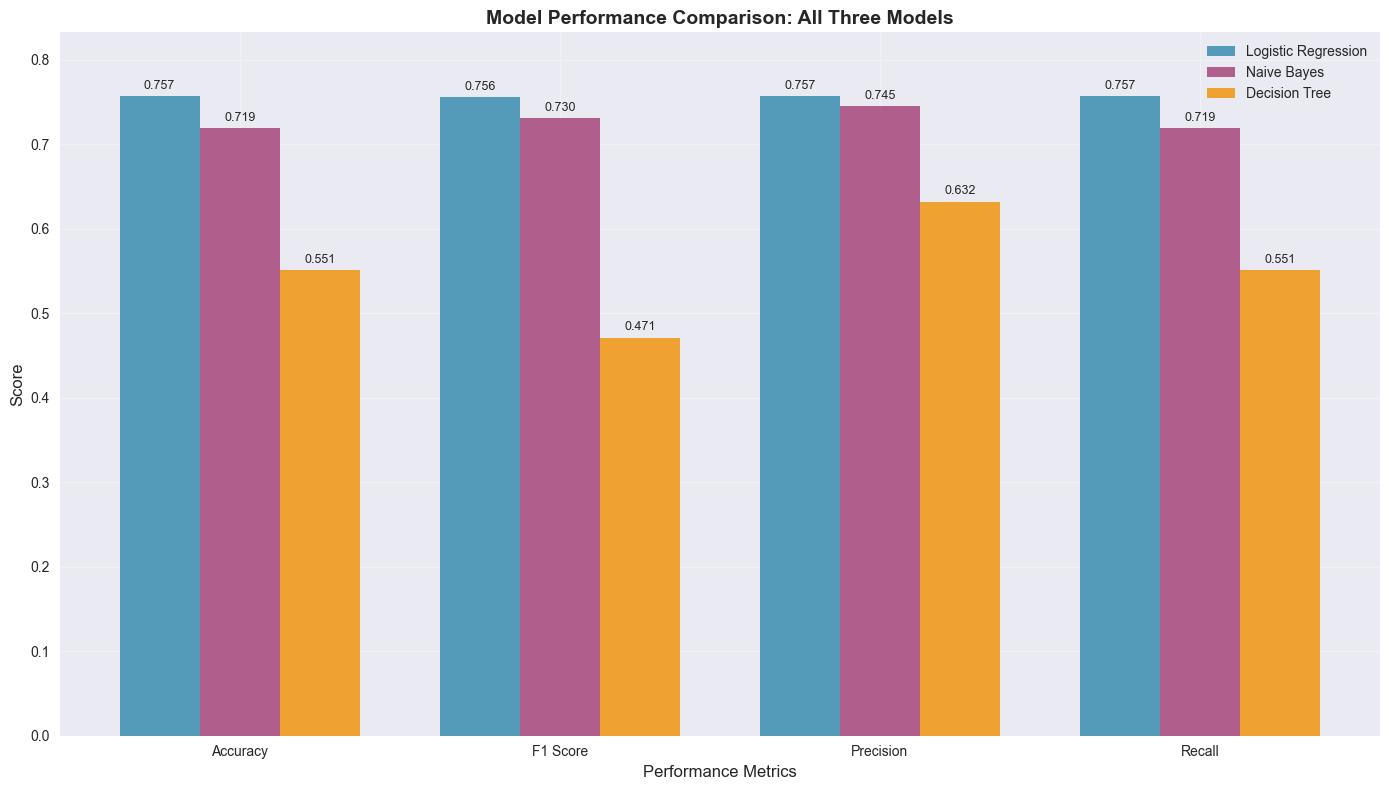

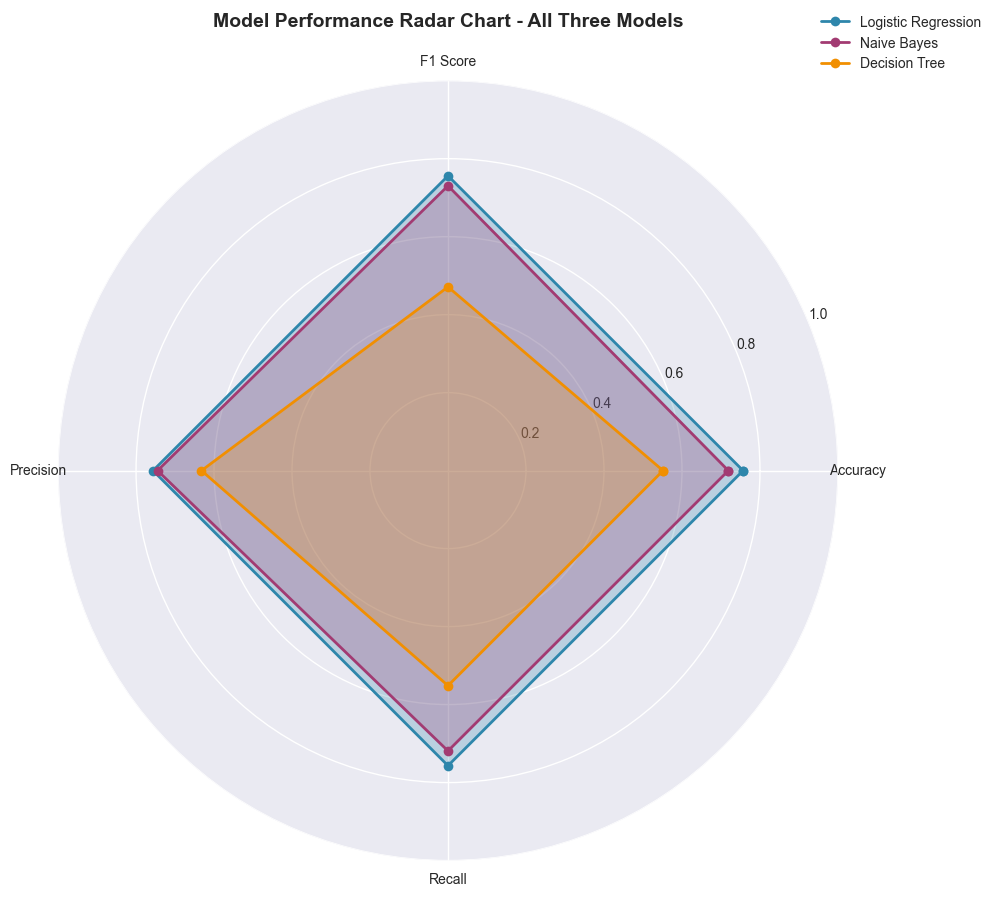

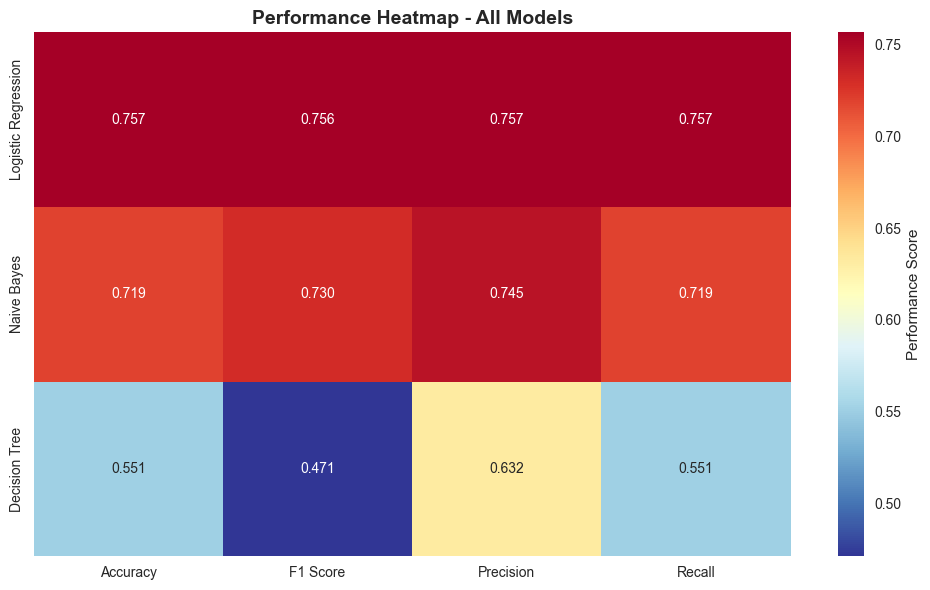


VISUALIZATION ANALYSIS SUMMARY


In [15]:
# --- 10. Model Performance Visualization - All Three Models ---

# Import required libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create performance data for visualization
models = ['Logistic Regression', 'Naive Bayes', 'Decision Tree']
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']

# Performance values
lr_values = [accuracy, f1_score, weighted_precision, weighted_recall]
nb_values = [nb_accuracy, nb_f1_score, nb_weighted_precision, nb_weighted_recall]
dt_values = [dt_accuracy, dt_f1_score, dt_weighted_precision, dt_weighted_recall]

# Create DataFrame for easier plotting
performance_df = pd.DataFrame({
    'Metric': metrics,
    'Logistic Regression': lr_values,
    'Naive Bayes': nb_values,
    'Decision Tree': dt_values
})

print("Performance Data:")
print(performance_df.round(4))

# --- 13.1 Side-by-Side Bar Chart ---
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(metrics))
width = 0.25

bars1 = ax.bar(x - width, lr_values, width, label='Logistic Regression', color='#2E86AB', alpha=0.8)
bars2 = ax.bar(x, nb_values, width, label='Naive Bayes', color='#A23B72', alpha=0.8)
bars3 = ax.bar(x + width, dt_values, width, label='Decision Tree', color='#F18F01', alpha=0.8)

# Add value labels on bars
for i, (bar1, bar2, bar3) in enumerate(zip(bars1, bars2, bars3)):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    height3 = bar3.get_height()
    ax.text(bar1.get_x() + bar1.get_width()/2., height1 + 0.005,
            f'{height1:.3f}', ha='center', va='bottom', fontsize=9)
    ax.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.005,
            f'{height2:.3f}', ha='center', va='bottom', fontsize=9)
    ax.text(bar3.get_x() + bar3.get_width()/2., height3 + 0.005,
            f'{height3:.3f}', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Performance Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison: All Three Models', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, max(max(lr_values), max(nb_values), max(dt_values)) * 1.1)

plt.tight_layout()
plt.show()

# --- 13.2 Radar Chart for Multi-dimensional Comparison ---
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Angles for each metric
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Close the circle

# Add values for closing the circle
lr_values_radar = lr_values + [lr_values[0]]
nb_values_radar = nb_values + [nb_values[0]]
dt_values_radar = dt_values + [dt_values[0]]

# Plot
ax.plot(angles, lr_values_radar, 'o-', linewidth=2, label='Logistic Regression', color='#2E86AB')
ax.fill(angles, lr_values_radar, alpha=0.25, color='#2E86AB')
ax.plot(angles, nb_values_radar, 'o-', linewidth=2, label='Naive Bayes', color='#A23B72')
ax.fill(angles, nb_values_radar, alpha=0.25, color='#A23B72')
ax.plot(angles, dt_values_radar, 'o-', linewidth=2, label='Decision Tree', color='#F18F01')
ax.fill(angles, dt_values_radar, alpha=0.25, color='#F18F01')

# Add labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.set_title('Model Performance Radar Chart - All Three Models', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
ax.grid(True)

plt.tight_layout()
plt.show()

# --- 13.3 Performance Summary Heatmap ---
fig, ax = plt.subplots(figsize=(10, 6))

# Create data matrix for heatmap
data_matrix = np.array([lr_values, nb_values, dt_values])

# Create heatmap
sns.heatmap(data_matrix, 
            xticklabels=metrics, 
            yticklabels=models,
            annot=True, 
            fmt='.3f', 
            cmap='RdYlBu_r',
            cbar_kws={'label': 'Performance Score'},
            ax=ax)

ax.set_title('Performance Heatmap - All Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("VISUALIZATION ANALYSIS SUMMARY")
print("="*80)

FINAL MODEL SELECTION RESULTS
Logistic Regression Overall Score: 0.7564
Naive Bayes Overall Score: 0.7274
Decision Tree Overall Score: 0.5315
------------------------------------------------------------
🏆 SELECTED MODEL: Logistic Regression
📊 Overall Performance Score: 0.7564
💾 Model Path: ../data/trained_model/lr


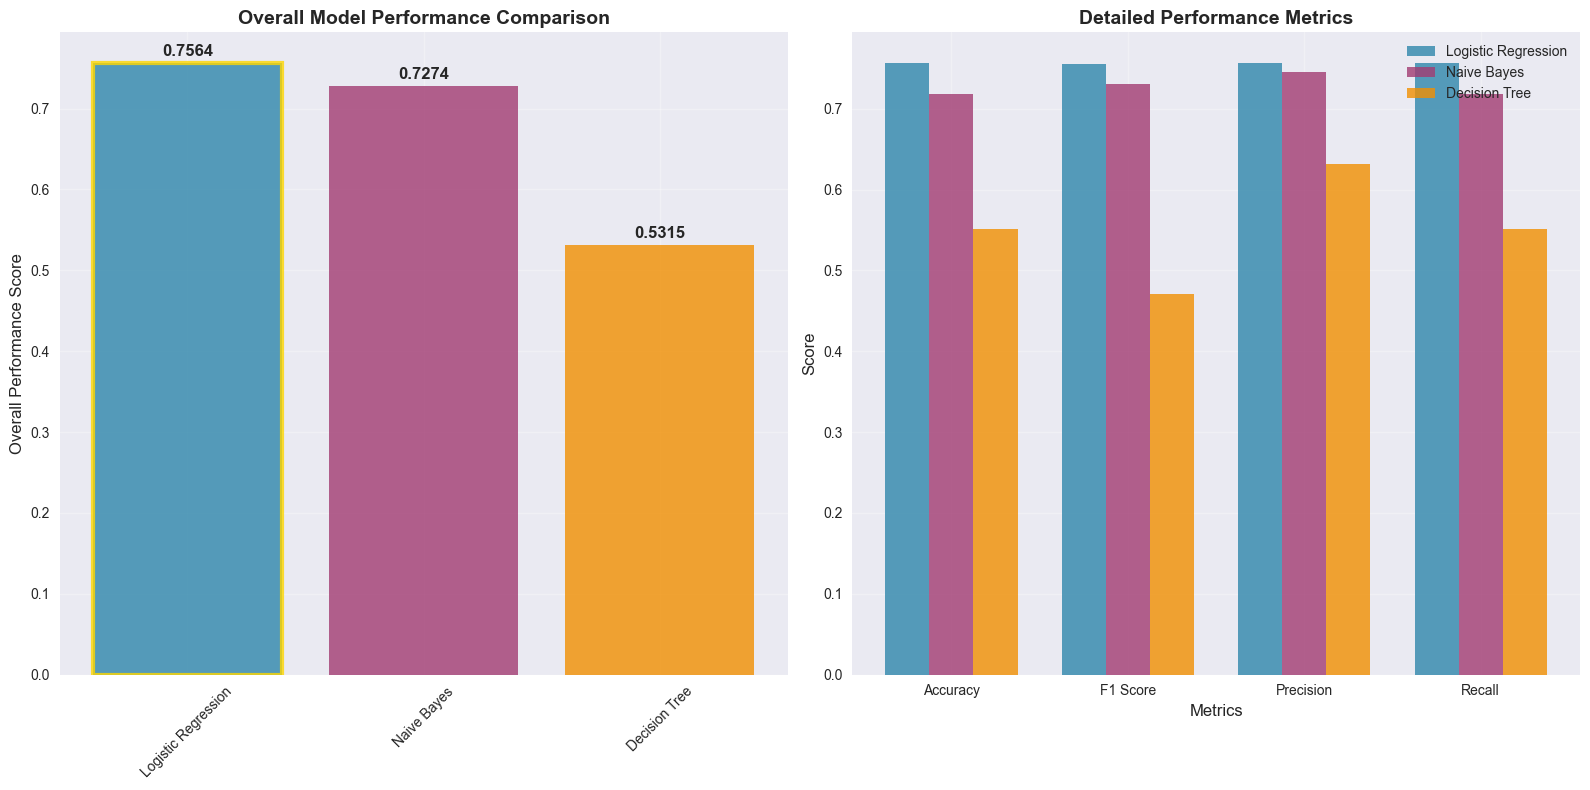


MODEL CHARACTERISTICS & RECOMMENDATIONS
✅ LOGISTIC REGRESSION SELECTED
📋 Characteristics:
   • Linear classifier with probabilistic output
   • Good for linearly separable data
   • Interpretable coefficients
   • Handles multi-class classification well
   • Generally faster in prediction

🚀 Suitable for:
   • Real-time processing (low latency)
   • Batch processing (good throughput)
   • Interpretable results needed

🎯 RECOMMENDATION FOR NEXT PHASE:
   Use Logistic Regression for both:
   • Real-time Kafka-Spark streaming pipeline
   • Batch processing for historical data analysis
   • Model path: ../data/trained_model/lr

🏅 FINAL MODEL RANKING:
🥇 1. Logistic Regression: 0.7564
🥈 2. Naive Bayes: 0.7274
🥉 3. Decision Tree: 0.5315



In [16]:
# --- 11. Final Model Selection for Real-Time & Batch Processing ---

# Calculate overall performance score (weighted average) for all three models
weights = {'accuracy': 0.3, 'f1': 0.4, 'precision': 0.15, 'recall': 0.15}

lr_overall_score = (accuracy * weights['accuracy'] + 
                   f1_score * weights['f1'] + 
                   weighted_precision * weights['precision'] + 
                   weighted_recall * weights['recall'])

nb_overall_score = (nb_accuracy * weights['accuracy'] + 
                   nb_f1_score * weights['f1'] + 
                   nb_weighted_precision * weights['precision'] + 
                   nb_weighted_recall * weights['recall'])

dt_overall_score = (dt_accuracy * weights['accuracy'] + 
                   dt_f1_score * weights['f1'] + 
                   dt_weighted_precision * weights['precision'] + 
                   dt_weighted_recall * weights['recall'])

print("FINAL MODEL SELECTION RESULTS")
print("="*60)
print(f"Logistic Regression Overall Score: {lr_overall_score:.4f}")
print(f"Naive Bayes Overall Score: {nb_overall_score:.4f}")
print(f"Decision Tree Overall Score: {dt_overall_score:.4f}")
print("-" * 60)

# Select the best model
all_overall_scores = [lr_overall_score, nb_overall_score, dt_overall_score]
model_names_final = ["Logistic Regression", "Naive Bayes", "Decision Tree"]
model_objects = [lr_model, nb_model, dt_model]
model_paths = ["../data/trained_model/lr", "../data/trained_model/nb", "../data/trained_model/dt"]

best_model_idx = all_overall_scores.index(max(all_overall_scores))
selected_model = model_names_final[best_model_idx]
selected_model_object = model_objects[best_model_idx]
selected_score = max(all_overall_scores)
model_save_path_final = model_paths[best_model_idx]

print(f"🏆 SELECTED MODEL: {selected_model}")
print(f"📊 Overall Performance Score: {selected_score:.4f}")
print(f"💾 Model Path: {model_save_path_final}")

# Create final visualization showing the selected model
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Overall Score Comparison
models_final = ['Logistic Regression', 'Naive Bayes', 'Decision Tree']
scores_final = [lr_overall_score, nb_overall_score, dt_overall_score]
colors_final = ['#2E86AB', '#A23B72', '#F18F01']

bars = ax1.bar(models_final, scores_final, color=colors_final, alpha=0.8)
ax1.set_ylabel('Overall Performance Score', fontsize=12)
ax1.set_title('Overall Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Add value labels
for bar, score in zip(bars, scores_final):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{score:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Highlight the winner
bars[best_model_idx].set_edgecolor('gold')
bars[best_model_idx].set_linewidth(3)

# All metrics comparison
metrics_all = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
lr_all = [accuracy, f1_score, weighted_precision, weighted_recall]
nb_all = [nb_accuracy, nb_f1_score, nb_weighted_precision, nb_weighted_recall]
dt_all = [dt_accuracy, dt_f1_score, dt_weighted_precision, dt_weighted_recall]

x = np.arange(len(metrics_all))
width = 0.25

bars1 = ax2.bar(x - width, lr_all, width, label='Logistic Regression', color='#2E86AB', alpha=0.8)
bars2 = ax2.bar(x, nb_all, width, label='Naive Bayes', color='#A23B72', alpha=0.8)
bars3 = ax2.bar(x + width, dt_all, width, label='Decision Tree', color='#F18F01', alpha=0.8)

ax2.set_xlabel('Metrics', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('Detailed Performance Metrics', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics_all)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Model characteristics and recommendations
print("\n" + "="*80)
print("MODEL CHARACTERISTICS & RECOMMENDATIONS")
print("="*80)

if selected_model == "Logistic Regression":
    print("✅ LOGISTIC REGRESSION SELECTED")
    print("📋 Characteristics:")
    print("   • Linear classifier with probabilistic output")
    print("   • Good for linearly separable data")
    print("   • Interpretable coefficients")
    print("   • Handles multi-class classification well")
    print("   • Generally faster in prediction")
    print("\n🚀 Suitable for:")
    print("   • Real-time processing (low latency)")
    print("   • Batch processing (good throughput)")
    print("   • Interpretable results needed")
    
elif selected_model == "Naive Bayes":
    print("✅ NAIVE BAYES SELECTED")
    print("📋 Characteristics:")
    print("   • Probabilistic classifier based on Bayes' theorem")
    print("   • Assumes feature independence")
    print("   • Good with small datasets")
    print("   • Handles text classification well")
    print("   • Fast training and prediction")
    print("\n🚀 Suitable for:")
    print("   • Real-time processing (very fast)")
    print("   • Batch processing (excellent throughput)")
    print("   • Text/document classification")

elif selected_model == "Decision Tree":
    print("✅ DECISION TREE SELECTED")
    print("📋 Characteristics:")
    print("   • Non-linear classifier with tree-based decisions")
    print("   • Highly interpretable (can visualize decision rules)")
    print("   • Handles feature interactions well")
    print("   • No need for feature scaling")
    print("   • Can capture non-linear patterns")
    print("\n🚀 Suitable for:")
    print("   • Real-time processing (fast predictions)")
    print("   • Batch processing (good throughput)")
    print("   • Explainable AI requirements")
    print("   • Non-linear data patterns")

print(f"\n🎯 RECOMMENDATION FOR NEXT PHASE:")
print(f"   Use {selected_model} for both:")
print(f"   • Real-time Kafka-Spark streaming pipeline")
print(f"   • Batch processing for historical data analysis")
print(f"   • Model path: {model_save_path_final}")

# Final ranking
print(f"\n🏅 FINAL MODEL RANKING:")
sorted_indices = sorted(range(len(all_overall_scores)), key=lambda i: all_overall_scores[i], reverse=True)
for rank, idx in enumerate(sorted_indices, 1):
    medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉"
    print(f"{medal} {rank}. {model_names_final[idx]}: {all_overall_scores[idx]:.4f}")

print("\n" + "="*80)

In [17]:
# --- Stop SparkSession ---
# Final cleanup: Stop the Spark session after all model training and analysis is complete
spark.stop()
print("\nSparkSession stopped successfully.")
print("All model training and evaluation completed!")



SparkSession stopped successfully.
All model training and evaluation completed!
